# Bayesian Machine Learning project

In [85]:
import torch 
from torch.distributions.chi2 import Chi2
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

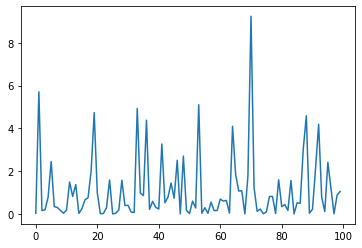

In [86]:
m = Chi2(torch.ones(100))
y = m.sample()
plt.plot(y)

In [87]:
class GMM() :
    def __init__(self) :
        self.sigma = 1
        self.centers = torch.Tensor([[8*i, 8*j] for i in [-2, -1, 0, 1, 2] for j in [-2, -1, 0, 1, 2]])
        chi2 = Chi2(torch.ones(25))
        omegas = chi2.sample()
        self.weights = omegas/torch.sum(omegas)

    def sample(self, n_sample=1000):
        indices = torch.multinomial(self.weights, num_samples=n_sample, replacement=True)
        sample = self.centers[indices] + torch.randn(n_sample, 2)*self.sigma
        return sample

In [88]:
n_sample = 10_000
gmm = GMM()

In [89]:
X = gmm.sample(n_sample=n_sample)

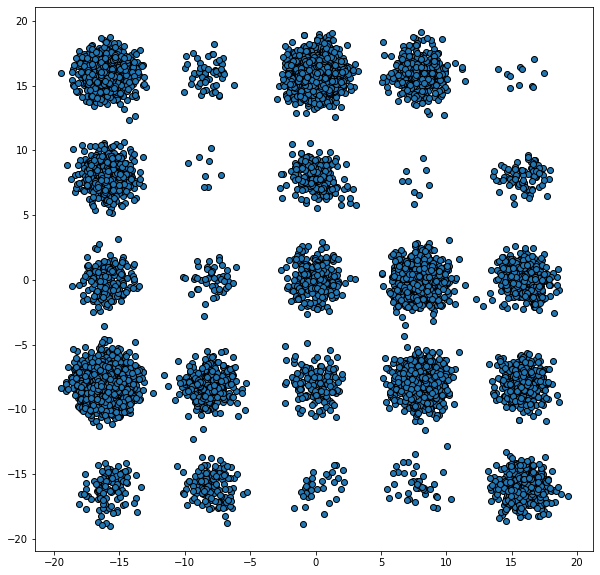

In [90]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(X[:,0], X[:,1], edgecolor="k")
plt.show()

In [130]:
class ESM():
    def __init__(self, beta_start=1e-4, beta_end=0.2, num_steps=1000):
        self.num_steps = num_steps
        self.betas = torch.linspace(beta_start, beta_end, num_steps)
        
        self.alphas = 1 - self.betas
        self.cum_alphas = torch.ones(num_steps+1)
        self.cum_alphas[1:] = torch.cumprod(self.alphas, dim=0)
        self.t = torch.linspace(0, 1, num_steps)
        self.gmm = GMM()

    def log_prob(self, x, i, t) :                           
        weights, means, sigma = self.gmm.weights, torch.sqrt(self.cum_alphas[t][i])*self.gmm.centers, self.gmm.sigma
        y = x[:, None] - means[None, :] 
        log_p = torch.log(weights[None, :]) - torch.sum(y**2, axis=-1) / (2*sigma**2)
        return torch.logsumexp(log_p, dim=-1)

    def score(self, x, i, t):
        outputs = self.log_prob(x, i, t).sum()
        grad = torch.autograd.grad(outputs, x)
        return grad[0]
        

    def forward(self, x0):
        xi = torch.clone(x0)
        x_seq = [xi]
        for i, beta in enumerate(self.betas) :
            z = torch.randn(x0.shape)
            xi = torch.sqrt(1 - beta)*xi + torch.sqrt(beta)*z 
            x_seq.append(xi)
        return x_seq

    def backward(self, xT):
        xi = torch.clone(xT)
        xi.requires_grad_(True)
        x_seq = [xi]
        times = torch.arange(self.num_steps-1, 0, step=-1)
        for i in tqdm(range(self.num_steps-1)):
            s_i = self.score(xi, i, times)
            mu_i = 1/torch.sqrt(self.alphas[times][i]) * (xi + self.betas[times][i] * s_i)
            xi = mu_i + torch.sqrt(self.betas[times][i])*torch.randn(xT.shape)
            x_seq.append(xi)
        return x_seq

In [106]:
def log_prob(x, gmm) :                           
    weights, means, sigma = gmm.weights, gmm.centers, gmm.sigma
    y = x[:, None] - means[None, :] 
    log_p = torch.log(weights[None, :]) - torch.sum(y**2, axis=-1) / (2*sigma**2)
    return (torch.logsumexp(log_p, dim=-1))

def score(x, gmm):
    x.requires_grad_(True)
    outputs = log_prob(x, gmm).sum()
    grad = torch.autograd.grad(outputs, x)
    print(grad)
    return grad[0]

In [145]:
torch.manual_seed(42)
N = 1000
esm = ESM(num_steps=N)

In [146]:
A = torch.linspace(20, -20, 200)
B = torch.linspace(-20, 20, 200)
T = torch.zeros((200, 200))
for i, y in enumerate(A) :
    for j, x in enumerate(B) :
        T[i, j] = log_prob(torch.Tensor([[x, y]]), esm.gmm)

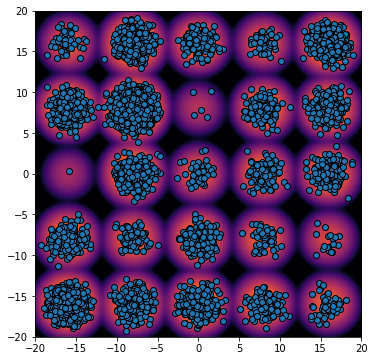

In [147]:
fig = plt.figure(figsize=(6, 6))
X = esm.gmm.sample(n_sample=n_sample)
plt.scatter(X[:,0], X[:,1], edgecolor="k")

plt.imshow(T, cmap="inferno", vmin=-15, vmax=0, extent=[-20, 20, -20, 20])

In [148]:
X = esm.gmm.sample(n_sample=n_sample)
x_forward = esm.forward(X)

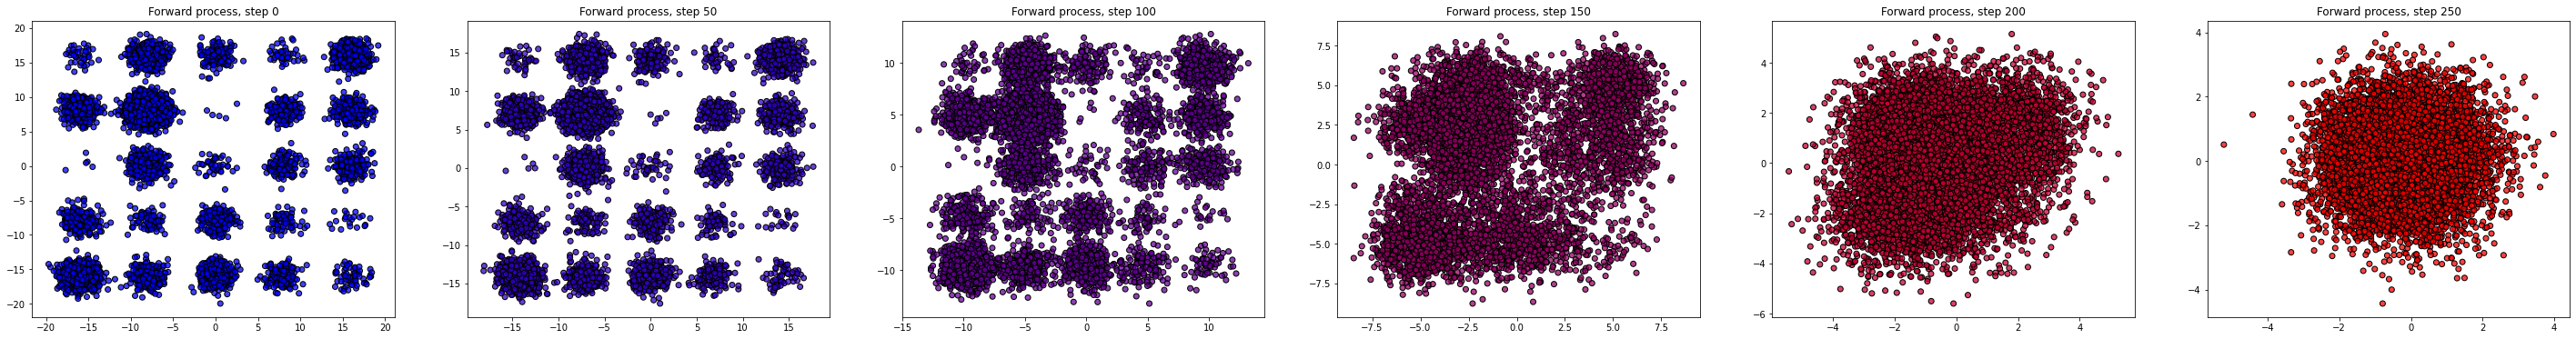

In [151]:
n_display = 6
idx = torch.arange(0, N, step=50)
s = torch.linspace(0, 1, steps=n_display)
fig, ax = plt.subplots(ncols=n_display, nrows=1, figsize=(50, 6))
for i in range(n_display) :
    c = [[s[i], 0, 1-s[i], 0.75] for _ in range(n_sample)]
    ax[i].scatter(x_forward[idx[i]][:,0], x_forward[idx[i]][:,1], edgecolor="k", c=c)
    ax[i].set_title("Forward process, step {}".format(idx[i]))
plt.show()

In [152]:
x_seq = esm.backward(x_forward[-1])

100%|██████████| 999/999 [00:04<00:00, 235.58it/s]


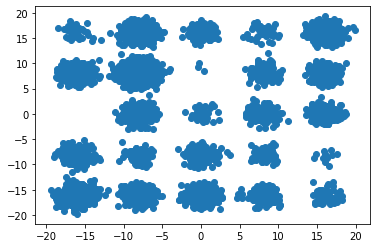

In [153]:
plt.scatter(x_seq[-1][:,0].detach(), x_seq[-1][:,1].detach())

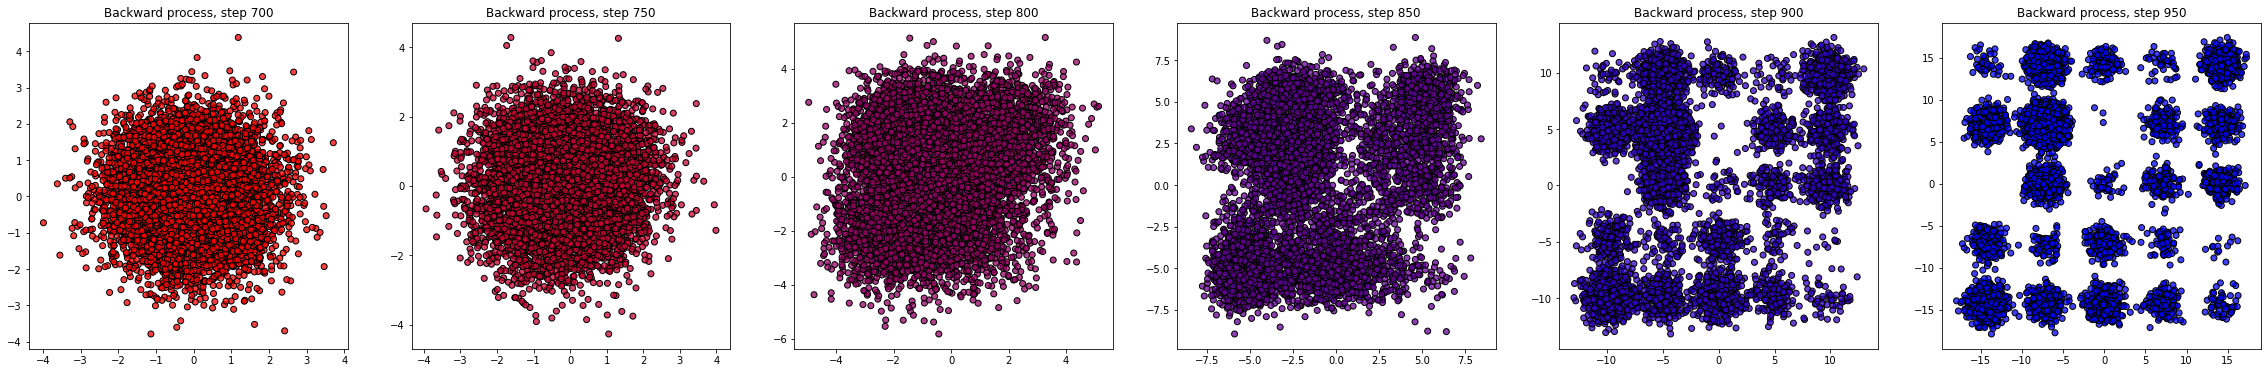

In [157]:
n_display = 6
idx = torch.arange(0, N, step=50)
s = torch.linspace(0, 1, steps=n_display)
fig, ax = plt.subplots(ncols=n_display, nrows=1, figsize=(40, 6))
for i in range(n_display) :
    c = [[s[i], 0, 1-s[i], 0.75] for _ in range(n_sample)]
    ax[-i-1].scatter(x_seq[idx[-i-1]][:,0].detach(), x_seq[idx[-i-1]][:,1].detach(), edgecolor="k", c=c)
    ax[-i-1].set_title("Backward process, step {}".format(idx[-i-1]))
plt.show()